# Load and preprocess DVS input for SNN

In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from snntoolbox.config import settings as s
from snntoolbox.io_utils.AedatTools.DVSIterator import extract_batch, load_event_sequence, get_eventframe_sequence

In [1]:
def get_label():
    from snntoolbox.io_utils.common import to_categorical
    label = None
    for key, value in label_dict.items():
        if value in filename:
            label = key
    
    # Each sample in the batch has the same label because it is generated
    # from the same DVS sequence.
    return np.broadcast_to(to_categorical([label], 4), (batch_size, 4))

## Load DVS sequences

In [3]:
path = '/home/rbodo/.snntoolbox/Datasets/roshambo/DVS_testset/background'
filename = sorted(os.listdir(path))[0]
filepath = os.path.join(path, filename)
label_dict = {'0': 'paper', '1': 'scissors', '2': 'rock', '3': 'background'}
xaddr_all, yaddr_all, timestamps_all = load_event_sequence(filepath, (239, 179))
x_b_xaddr, x_b_yaddr, x_b_ts, y_b = extract_batch(xaddr_all, yaddr_all, timestamps_all, 10, 0, 2000)

Loading DVS sample /home/rbodo/.snntoolbox/Datasets/roshambo/DVS_4/background/background_20.aedat...


Discarded 128 events during 3-sigma standardization.
Discarded 145 events during 3-sigma standardization.
Discarded 168 events during 3-sigma standardization.
Discarded 301 events during 3-sigma standardization.
Discarded 191 events during 3-sigma standardization.
Discarded 264 events during 3-sigma standardization.
Discarded 251 events during 3-sigma standardization.
Discarded 106 events during 3-sigma standardization.
Discarded 233 events during 3-sigma standardization.
Discarded 206 events during 3-sigma standardization.


## Plot an "event-frame" consisting of 2000 events

(0, 179)

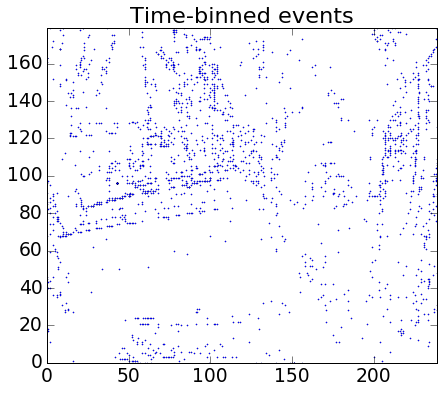

In [5]:
frame_idx = 0
width = 2000
plt.scatter(xaddr_all[frame_idx*width:(frame_idx+1)*width], yaddr_all[frame_idx*width:(frame_idx+1)*width], s=2, linewidths=0.1)
plt.title('Time-binned events')
plt.xlim(0, 239)
plt.ylim(0, 179)

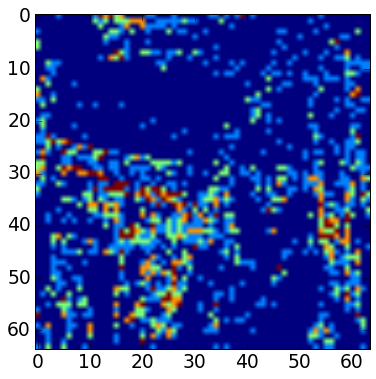

In [7]:
frame_idx = 0
img = np.zeros((64, 64))
for x, y in zip(x_b_xaddr[frame_idx], x_b_yaddr[frame_idx]):
    img[y, x] += 1
plt.imshow(img)

In [2]:
frame_width = 1000
xaddr_sample = x_b_xaddr[0].copy()
yaddr_sample = x_b_yaddr[0].copy()
timestamps_sample = x_b_ts[0].copy()
inp = get_eventframe_sequence(xaddr_sample, yaddr_sample, timestamps_sample, (64, 64), frame_width)
num_frames = inp.shape[-1]
print("Generated {} binary event maps.".format(num_frames))

NameError: name 'x_b_xaddr' is not defined

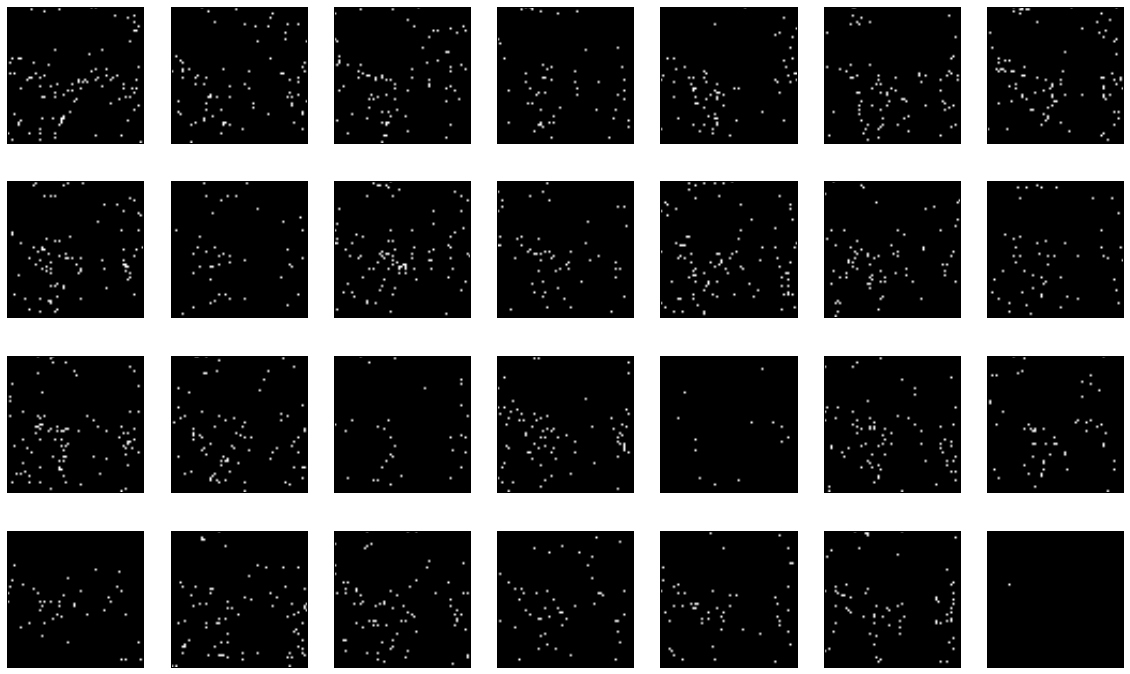

In [13]:
nrows = 4
ncols = 7
fig = plt.figure(figsize=(20, 12))
axes = [fig.add_subplot(nrows, ncols, 1 + r * ncols + c) for r in range(nrows) for c in range(ncols)]

for i, ax in enumerate(axes):
    ax.imshow(inp[..., i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

## Plot accumulation of all events

In [8]:
plt.scatter(xaddr_all, yaddr_all, s=2, linewidths=0.1)
plt.title('Accumulated event sequence')
plt.xlim(0, None)
plt.ylim(0, None)

(0, 200.0)

## Plot timestamps of event sequence

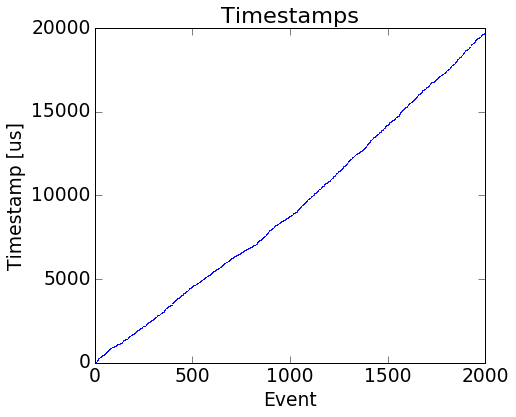

In [19]:
plt.plot(timestamps_all[:2000]-timestamps_all[0], '.', markersize=1)
plt.title('Timestamps')
plt.xlabel('Event')
plt.ylabel('Timestamp [us]')

## Compare different sub-sampling techniques

In [141]:
from PIL import Image

x_test_sub1 = []
x_test_full = []  # Not downsampled
snapshot_durations = []
# Loop over all samples
for x_list, y_list, ts_list in zip(xaddr_all, yaddr_all, timestamps_all):
    # Snapshot with at most one event per pixel
    inp_shallow = np.zeros((180, 240))
    # List of snapshots
    inp_t = []
    inp_t_full = []  # not downsampled
    # List of latest timestamps per snapshot
    inp_ts = []
    # Loop over all events of sample
    for e_x, e_y, e_ts in zip(x_list, y_list, ts_list):
        if inp_shallow[e_y, e_x] == 0:
            inp_shallow[e_y, e_x] += 1
        else:
            # Downsample snapshot and add it to the others
            inp_downsampled = np.array(Image.fromarray(inp_shallow).resize((64, 64)), ndmin=3)
            inp_t.append(inp_downsampled)
            inp_t_full.append(inp_shallow)
            inp_ts.append(e_ts)
            # Start new snapshot
            inp_shallow = np.zeros((180, 240))
    x_test_sub1.append(np.array(inp_t, 'float32'))
    x_test_full.append(np.array(inp_t_full, 'float32'))
    snapshot_durations.append(np.diff(inp_ts))

In [142]:
from skimage.measure import block_reduce
x_test_sub2 = []
x_test_sub3 = []
for sample in x_test_full:
    x_test_sub2.append(np.pad(block_reduce(sample, (1, 3, 4), np.max), ((0, 0), (2, 2), (2, 2)), 'constant', constant_values=0))
    x_test_sub3.append(np.pad(block_reduce(sample, (1, 3, 4), np.sum), ((0, 0), (2, 2), (2, 2)), 'constant', constant_values=0))

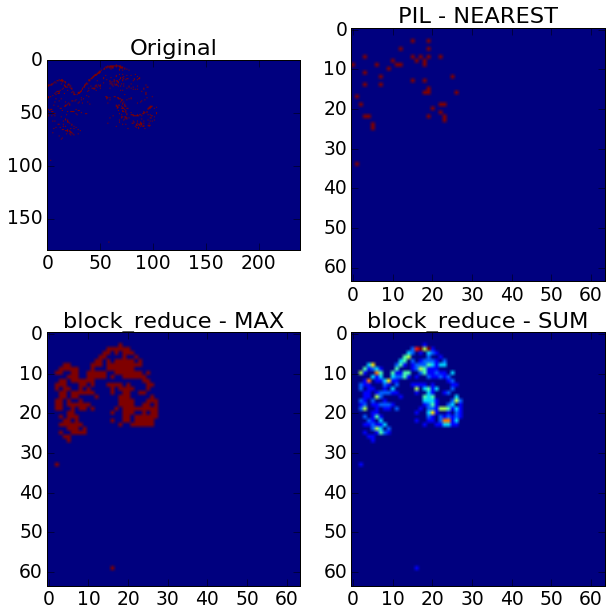

In [146]:
sample_idx = 0
snapshot_idx = 5000

f, ax = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
ax[0, 0].imshow(np.squeeze(x_test_full[sample_idx][snapshot_idx]))
ax[0, 1].imshow(np.squeeze(x_test_sub1[sample_idx][snapshot_idx]))
ax[1, 0].imshow(np.squeeze(x_test_sub2[sample_idx][snapshot_idx]))
ax[1, 1].imshow(np.squeeze(x_test_sub3[sample_idx][snapshot_idx]))
ax[0, 0].set_title("Original")
ax[0, 1].set_title("PIL - NEAREST")
ax[1, 0].set_title("block_reduce - MAX")
ax[1, 1].set_title("block_reduce - SUM")

In [4]:
from snntoolbox.io_utils.AedatTools.DVSIterator import DVSIterator

batch_size = 50
num_events_per_sample = 2000
frame_width = 10
duration = 300
batch_shape = (batch_size, 1, 64, 64)
label_dict_rev= {'paper': '0', 'scissors': '1', 'rock': '2', 'background': '3'}
path = '/home/rbodo/.snntoolbox/Datasets/roshambo/DVS_paper'
dvs_gen = DVSIterator(path, batch_shape, frame_width, num_events_per_sample,
                      label_dict_rev, (239/63, 179/63))
num_batches = len(os.listdir('/home/rbodo/.snntoolbox/data/roshambo/log/gui/20/log_vars__paper'))
input_b_l_t = np.empty(batch_shape + (duration,), np.bool)

for batch_idx in range(num_batches):
    try:
        dvs_gen.next_sequence_batch()
    except StopIteration:
        break
    
    for sim_step in range(duration):
        input_b_l_t[Ellipsis, sim_step] = dvs_gen.next_eventframe_batch()
        
    np.savez_compressed('/home/rbodo/Downloads/log_vars2/' + str(batch_idx), input_b_l_t=input_b_l_t)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rbodo/.snntoolbox/Datasets/roshambo/DVS_paper'

In [5]:
# Save cumulated input spikes from DVS sequences. 

from snntoolbox.io_utils.AedatTools.DVSIterator import DVSIterator

num_events_per_sample = 2000
frame_width = 10
duration = 700
batch_shape = (1, 1, 64, 64)
label_dict_rev = {'paper': '0', 'scissors': '1', 'rock': '2', 'background': '3'}
path = '/home/rbodo/.snntoolbox/Datasets/roshambo/DVS_background'
dvs_gen = DVSIterator(path, batch_shape, frame_width, num_events_per_sample, 
                      label_dict_rev, (239/63, 179/63))
spikecounts_d_l = []

while True:
    try:
        dvs_gen.next_sequence_batch()
    except StopIteration:
        break
    
    acc_inp = np.zeros(batch_shape, np.int)
    
    for sim_step in range(duration):
        acc_inp += dvs_gen.next_eventframe_batch()
    
    spikecounts_d_l.append(acc_inp)

np.savez_compressed('/home/rbodo/.snntoolbox/data/roshambo/log/gui/6_debug/spikecounts_bg',
                    spikecounts_d_l=np.array(spikecounts_d_l, 'float32'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/rbodo/.snntoolbox/Datasets/roshambo/DVS_background'

In [3]:
# Accumulate analog frames from Poisson trains.
path_to_dataset = '/home/rbodo/.snntoolbox/Datasets/roshambo/frames_testset'
x_test = np.load(os.path.join(path_to_dataset, 'x_test.npz'))['arr_0']
num_events_per_frame = 1850
input_rate = 8
tec = []
x_new = []
for sample in x_test:
    new_sample = np.zeros_like(sample)
    total_event_count = 0
    while total_event_count < num_events_per_frame:
        spike_snapshot = np.random.random_sample(sample.shape) * 1000 / input_rate
        new_sample += (spike_snapshot <= sample).astype('float32')
        total_event_count = np.sum(new_sample)
    x_new.append(new_sample)
    tec.append(total_event_count)

np.savez_compressed(os.path.join(path_to_dataset, 'Poisson2000', 'x_test'), np.array(x_new, dtype='float32'))

In [4]:
np.mean(tec)

1851.1261

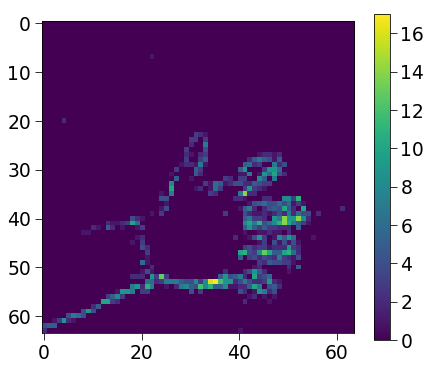

In [5]:
plt.imshow(x_new[0][0])
plt.colorbar()

In [6]:
# Accumulate Poisson frames without limiting the number of spikes.

num_timesteps = 150
input_rate = 1000
x_new = []
for sample in x_test:
    new_sample = np.zeros_like(sample)
    for t in range(num_timesteps):
        spike_snapshot = np.random.random_sample(sample.shape) * 1000 / input_rate
        new_sample += (spike_snapshot <= sample).astype('float32')
    x_new.append(new_sample)

np.savez_compressed(os.path.join(path_to_dataset, 'Poisson', 'x_test'), np.array(x_new, dtype='float32'))